In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import time
import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
#import seaborn as sns

from builtins import max as max_n

from scipy import stats
from scipy.stats import entropy

import pyspark
from pyspark import SparkConf, SparkContext , HiveContext
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, HiveContext
from pyspark.sql.functions import *
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [2]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

2023-11-14 10:16:41.772673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 10:16:41.804497: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 10:16:41.804552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 10:16:41.804580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 10:16:41.810024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 10:16:41.810686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
# config.load('we-offshore')
conf = SparkConf().set("spark.hadoop.fs.s3a.endpoint",'https://s3api-core.uhc.com')\
            .set("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")\
            .set("spark.hadoop.fs.s3a.access.key",'pQffiGbavztAv6oHYubm')\
            .set("spark.hadoop.fs.s3a.secret.key", 'Mb8uUAIn58YWsalinBwDrkShBjNbv0zXiwa9jFR6')\
            .set("com.amazonaws.services.s3a.enableV4", "true")\
            .set("spark.hadoop.fs.s3a.path.style.access","true")\
            .set("spark.hadoop.s3a.connection.ssl.enabled","false")\
            .set("fs.s3a.connection.ssl.enabled","true")\
            .set("spark.sql.shuffle.partitions", "1000")\
            .set("spark.driver.memory", "64g")\
            .set("spark.executor.memory", "8g")\
            .set("spark.executor.cores", "4") \
            .set("spark.executor.instances", "4") \
            .set("spark.kubernetes.executor.limit.cores", "4")\
            .set("spark.kubernetes.executor.request.cores", "2500m")\
            .set("spark.driver.maxResultSize","64g")\
            .set("spark.executor.memoryOverhead","4096")\
            .set("spark.sql.broadcastTimeout", "36000")\
            .set("spark.sql.crossJoin.enabled" , "true")\
            .set("spark.sql.parquet.datetimeRebaseMode", "CORRECTED")\
            .set("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED")\
            .set("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED")\
            .set("spark.sql.legacy.parquet.datetimeRebaseModeInRead", "CORRECTED")\
            .set("spark.sql.legacy.parquet.datetimeRebaseModeInWrite", "CORRECTED")\
            .set("spark.sql.legacy.parquet.int96RebaseModeInRead", "CORRECTED")\
            .set("spark.sql.legacy.parquet.int96RebaseModeInWrite", "CORRECTED")

In [5]:
# Starting spark session

spark = SparkSession.builder.appName("mp-GAN").config(conf = conf).getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

https://repo1.uhc.com/artifactory/repo added as a remote repository with the name: repo-1
https://repo1.uhc.com/artifactory/UHG-Snapshots added as a remote repository with the name: repo-2
https://repo1.uhc.com/artifactory/UHG-Releases added as a remote repository with the name: repo-3
2023-11-14 10:17:19,616 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
log4j = spark._jvm.org.apache.log4j
log4j.LogManager.getRootLogger().setLevel(log4j.Level.ERROR)

In [7]:
spark

In [8]:
# spark.stop()
# spark.sparkContext.stop()

In [9]:
base_loc = "s3a://ss-bucket/GAN_v5/"
data_loc = base_loc + 'data/'
data_loc_1 = base_loc + 'data-1/'

# Calculating Metrics

In [10]:
def calc_cf_metrics (target, pred):
    tp = 0 # True Positive
    tn = 0 # True Negative
    fp = 0 # False Positive
    fn = 0 # False Negative
    
    for i in range(len(target)):
        if (target[i] == 1) and (pred[i] == 1):
            tp += 1
        if (target[i] == 1) and (pred[i] == 0):
            fn += 1
        if (target[i] == 0) and (pred[i] == 0):
            tn += 1
        if (target[i] == 0) and (pred[i] == 1):
            fp += 1
    
    if (tp + fn + tn + fp) != 0:
        accuracy = (tp + tn) / (tp + fn + tn + fp)
    else:
        accuracy = 'zero den'
    
    if (tp + fp) != 0:
        precision_pos_class = tp / (tp + fp)
    else:
        precision_pos_class = 'zero den'
    
    if (fn + tn) != 0:
        precision_neg_class = tn / (fn + tn)
    else:
        precision_neg_class = 'zero den'
    
    if (tp + fn) != 0:
        recall_pos_class = tp / (tp + fn)
    else:
        recall_pos_class = 'zero den'
        
    if (tn + fp) != 0:
        recall_neg_class = tn / (tn + fp)
    else:
        recall_neg_class = 'zero den'
    
    if (precision_pos_class != 'zero den') and (recall_pos_class != 'zero den') and ((precision_pos_class + recall_pos_class) != 0):
        f1_score_pos_class = (2 * precision_pos_class * recall_pos_class) / (precision_pos_class + recall_pos_class)
    else:
        f1_score_pos_class = 'zero den'

    if (precision_neg_class != 'zero den') and (recall_neg_class != 'zero den') and ((precision_neg_class + recall_neg_class) != 0):
        f1_score_neg_class = (2 * precision_neg_class * recall_neg_class) / (precision_neg_class + recall_neg_class)
    else:
        f1_score_neg_class = 'zero den'
        
    if (len(target) == (tp + fn + tn + fp)):
        print(f'Accuracy: {accuracy}')
        print(f'Precision (Positive Class): {precision_pos_class}')
        print(f'Recall (Positive Class): {recall_pos_class}')
        print(f'F1 score (Positive Class): {f1_score_pos_class}')
        print(f'Precision (Negative class): {precision_neg_class}')
        print(f'Recall (Negative class): {recall_neg_class}')
        print(f'F1 score (Negative class): {f1_score_neg_class}')
        
        return [accuracy, 
                precision_pos_class, recall_pos_class, f1_score_pos_class, 
                precision_neg_class, recall_neg_class, f1_score_neg_class]
    else:
        print('ERROR')

### Train test load

In [11]:
train_loc = data_loc + 'train_claims_data_2/' # Train data location
test_loc = data_loc + 'test_claims_data_1/' # Test data location

train_data = spark.read.parquet(train_loc + '*.parquet') # Train data
test_data = spark.read.parquet(test_loc + '*.parquet') # Test data

In [11]:
train_data.count(), \
len(train_data.columns), \
train_data.select('cli_clm_id').distinct().count(), \
train_data.select('ufe_claim_id').distinct().count() # (1041514, 50, 253398, 253398)

(1041514, 50, 253398, 253398)

In [12]:
test_data.count(), \
len(test_data.columns), \
test_data.select('cli_clm_id').distinct().count(), \
test_data.select('ufe_claim_id').distinct().count() # (912480, 47, 173520, 173520)

(912480, 47, 173520, 173520)

# Feature Selection

In [13]:
# These are the existing data variables, which I have in S3

# If you want to add any new feature other than these existing variables, 
# then you will be required to make new train/test data, which cannot be done using this code.

train_data.columns

['ufe_claim_id',
 'cli_clm_id',
 'clm_ln_nbr',
 'lob',
 'lob_flag',
 'aso_buyup',
 'clm_pl_of_srvc_cd',
 'load_dt',
 'load_dt_date',
 'load_dt_month',
 'load_dt_year',
 'bil_prov_npi',
 'bil_prov_city',
 'bil_prov_st',
 'bil_prov_zip_cd',
 'bil_prov_txnmy_cd',
 'ptnt_city',
 'ptnt_st',
 'ptnt_zip_cd',
 'ptnt_gdr',
 'ptnt_dob',
 'clm_tot_bil_amt',
 'ln_bil_amt',
 'sbmt_proc_cd',
 'sbmt_proc_mod_1_cd',
 'sbmt_proc_mod_2_cd',
 'sbmt_proc_mod_3_cd',
 'sbmt_proc_mod_4_cd',
 'sbmt_unit_of_srvc_qty',
 'diag_cd1',
 'diag_cd2',
 'diag_cd3',
 'diag_cd4',
 'diag_cd5',
 'diag_cd6',
 'diag_cd7',
 'diag_cd8',
 'diag_cd9',
 'diag_cd10',
 'diag_cd11',
 'diag_cd12',
 'diag_cd_1',
 'diag_cd_2',
 'diag_cd_3',
 'diag_cd_4',
 'map_fwae_disposition',
 'ln_lvl_adjd_disposition',
 'net_range',
 'clm_ln_nbr_int',
 'paid_flag']

In [39]:
# To add any new feature, you can add any of the existing column in this list.
# Note: It will be automatically fetched in test data features also.

# In this version of the code, adding a categorical variable is easy and possible.
# But if you want to add any numerical variable it will require some extra changes, which might be confusing to do.
# If time permits, I will share another version with that functionality as well.
# Although I have only one numerical variable saved in data and that is claim/line level billed amount.
# So it might not be of much help.
train_data_cols = ['sbmt_proc_cd', 'sbmt_proc_mod_1_cd', 'sbmt_proc_mod_2_cd', 
                   'diag_cd1',
                   'bil_prov_txnmy_cd', 'ln_bil_amt', 'aso_buyup', 'clm_pl_of_srvc_cd']
train_data_1 = train_data.select(train_data_cols)
train_data_1.count()

1041514

In [40]:
# Selecting same features from test
test_data_cols = ['ufe_claim_id', 'cli_clm_id'] + train_data_cols + ['map_fwae_disposition']
test_data_1 = test_data.select(test_data_cols)
test_data_1.columns

['ufe_claim_id',
 'cli_clm_id',
 'sbmt_proc_cd',
 'sbmt_proc_mod_1_cd',
 'sbmt_proc_mod_2_cd',
 'diag_cd1',
 'bil_prov_txnmy_cd',
 'ln_bil_amt',
 'aso_buyup',
 'clm_pl_of_srvc_cd',
 'map_fwae_disposition']

In [41]:
train_data_2 = train_data_1.dropDuplicates(train_data_cols)
train_data_2.count()

491756

In [42]:
def find_mode(data):
    # Function to find mode for all the columns of input data
    # If multiple values has same count ie. multiple modes, then first value will be fetched
    # This will return a dictionary, where keys are column names and values are corresponding mode
    mode = {}
    for col in data.columns:
        print(f'Calculating mode for: {col}')
        col_mode = data.groupBy(col).count().sort('count', ascending=False).collect()[0][0]
        if col_mode is None:
            col_mode = data.groupBy(col).count().sort('count', ascending=False).collect()[1][0]
            mode[col] = col_mode
        else:
            mode[col] = col_mode
        
    return mode

In [43]:
# Checking % NULL count
tot_lines = train_data_2.count()
for col in train_data_2.columns:
    null_pct = ((train_data_2.filter(train_data_2[col].isNull()).count()) / tot_lines) * 100
    print(f'{col}:{null_pct}')

sbmt_proc_cd:0.0
sbmt_proc_mod_1_cd:69.0124777328594
sbmt_proc_mod_2_cd:95.16040475357698
diag_cd1:0.0
bil_prov_txnmy_cd:0.954945135392349
ln_bil_amt:0.0
aso_buyup:0.0
clm_pl_of_srvc_cd:0.0


In [44]:
# Checking % NULL count
tot_lines = test_data_1.count()

for col in test_data_1.columns:
    null_pct = ((test_data_1.filter(test_data_1[col].isNull()).count()) / tot_lines) * 100
    print(f'{col}:{null_pct}')

ufe_claim_id:0.0
cli_clm_id:0.0
sbmt_proc_cd:0.0
sbmt_proc_mod_1_cd:70.0037261090654
sbmt_proc_mod_2_cd:94.40327459231983
diag_cd1:0.0
bil_prov_txnmy_cd:0.4997369805365597
ln_bil_amt:0.0
aso_buyup:0.0
clm_pl_of_srvc_cd:0.0
map_fwae_disposition:0.0


In [46]:
train_data_2 = train_data_2.na.fill(value='0')
test_data_2 = test_data_1.na.fill(value='0')

In [47]:
# Checking % NULL count
tot_lines = train_data_2.count()
for col in train_data_2.columns:
    null_pct = ((train_data_2.filter(train_data_2[col].isNull()).count()) / tot_lines) * 100
    print(f'{col}:{null_pct}')

sbmt_proc_cd:0.0
sbmt_proc_mod_1_cd:0.0
sbmt_proc_mod_2_cd:0.0
diag_cd1:0.0
bil_prov_txnmy_cd:0.0
ln_bil_amt:0.0
aso_buyup:0.0
clm_pl_of_srvc_cd:0.0


In [48]:
# Checking % NULL count
tot_lines = test_data_2.count()

for col in test_data_2.columns:
    null_pct = ((test_data_2.filter(test_data_2[col].isNull()).count()) / tot_lines) * 100
    print(f'{col}:{null_pct}')

ufe_claim_id:0.0
cli_clm_id:0.0
sbmt_proc_cd:0.0
sbmt_proc_mod_1_cd:0.0
sbmt_proc_mod_2_cd:0.0
diag_cd1:0.0
bil_prov_txnmy_cd:0.0
ln_bil_amt:0.0
aso_buyup:0.0
clm_pl_of_srvc_cd:0.0
map_fwae_disposition:0.0


## Converting these datas to Pandas

In [49]:
train_data_3_pd = train_data_2.toPandas()

In [50]:
print(train_data_3_pd.shape) # (491756, 8)
train_data_3_pd.info()

(491756, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491756 entries, 0 to 491755
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sbmt_proc_cd        491756 non-null  object
 1   sbmt_proc_mod_1_cd  491756 non-null  object
 2   sbmt_proc_mod_2_cd  491756 non-null  object
 3   diag_cd1            491756 non-null  object
 4   bil_prov_txnmy_cd   491756 non-null  object
 5   ln_bil_amt          491756 non-null  object
 6   aso_buyup           491756 non-null  int32 
 7   clm_pl_of_srvc_cd   491756 non-null  object
dtypes: int32(1), object(7)
memory usage: 28.1+ MB


In [51]:
test_data_2_pd = test_data_2.toPandas()
print(test_data_2_pd.shape) # (912480, 11)
test_data_2_pd.info()

(912480, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912480 entries, 0 to 912479
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ufe_claim_id          912480 non-null  int64 
 1   cli_clm_id            912480 non-null  object
 2   sbmt_proc_cd          912480 non-null  object
 3   sbmt_proc_mod_1_cd    912480 non-null  object
 4   sbmt_proc_mod_2_cd    912480 non-null  object
 5   diag_cd1              912480 non-null  object
 6   bil_prov_txnmy_cd     912480 non-null  object
 7   ln_bil_amt            912480 non-null  object
 8   aso_buyup             912480 non-null  int32 
 9   clm_pl_of_srvc_cd     912480 non-null  object
 10  map_fwae_disposition  912480 non-null  object
dtypes: int32(1), int64(1), object(9)
memory usage: 73.1+ MB


## Label Encoding

In [77]:
train_data_3_pd['ln_bil_amt'] = train_data_3_pd['ln_bil_amt'].astype(float)
test_data_2_pd['ln_bil_amt'] = test_data_2_pd['ln_bil_amt'].astype(float)

train_data_3_pd['aso_buyup'] = train_data_3_pd['aso_buyup'].astype(str)
test_data_2_pd['aso_buyup'] = test_data_2_pd['aso_buyup'].astype(str)

#train
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>=0) & (train_data_3_pd.ln_bil_amt<=100), 'bill_amount_category'] = '0-100'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>100) & (train_data_3_pd.ln_bil_amt<=200), 'bill_amount_category'] = '101-200'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>200) & (train_data_3_pd.ln_bil_amt<=500), 'bill_amount_category'] = '201-500'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>500) & (train_data_3_pd.ln_bil_amt<=1000), 'bill_amount_category'] = '501-1000'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>1000) & (train_data_3_pd.ln_bil_amt<=2000), 'bill_amount_category'] = '1001-2000'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>2000) & (train_data_3_pd.ln_bil_amt<=5000), 'bill_amount_category'] = '2001-5000'
train_data_3_pd.loc[(train_data_3_pd.ln_bil_amt>5000), 'bill_amount_category'] = '5000+'

#test
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>=0) & (test_data_2_pd.ln_bil_amt<=100), 'bill_amount_category'] = '0-100'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>100) & (test_data_2_pd.ln_bil_amt<=200), 'bill_amount_category'] = '101-200'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>200) & (test_data_2_pd.ln_bil_amt<=500), 'bill_amount_category'] = '201-500'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>500) & (test_data_2_pd.ln_bil_amt<=1000), 'bill_amount_category'] = '501-1000'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>1000) & (test_data_2_pd.ln_bil_amt<=2000), 'bill_amount_category'] = '1001-2000'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>2000) & (test_data_2_pd.ln_bil_amt<=5000), 'bill_amount_category'] = '2001-5000'
test_data_2_pd.loc[(test_data_2_pd.ln_bil_amt>5000), 'bill_amount_category'] = '5000+'


In [79]:
# Categorical columns list
# All categorical columns are being label encoded
# If you are adding any new categorical feature, 
# then that feature needs to be added here also, so as to perform label encoding on that.
catCols = ['sbmt_proc_cd', 'sbmt_proc_mod_1_cd', 'sbmt_proc_mod_2_cd', 'diag_cd1',
            'bil_prov_txnmy_cd', 'bill_amount_category', 'aso_buyup', 'clm_pl_of_srvc_cd']

In [80]:
# headers of label encoded columns (output of label encoder)
catCols_enc = [x + '_label_enc' for x in catCols]
train_data_3_pd = train_data_3_pd.reset_index(drop=True)
test_data_2_pd = test_data_2_pd.reset_index(drop=True)

##### Splitting test data into two parts
Test data is being split into two parts. One part contains identifer columns which are not to be label encoded. Other part is features that need to label encode.
<br>Part-1: identifiers columns ['ufe_claim_id', 'cli_clm_id', 'map_fwae_disposition']
<br>Part-2: features columns

In [81]:
test_data_2_pd_p1 = test_data_2_pd[['ufe_claim_id', 'cli_clm_id', 'map_fwae_disposition']]
test_data_2_pd_p2 = test_data_2_pd[catCols]
test_data_2_pd_p1.head(15)

,ufe_claim_id,cli_clm_id,map_fwae_disposition
0,923223431728500,923223431728500,Denied after Investigation
1,923223431728500,923223431728500,Denied after Investigation
2,923223431727700,923223431727700,Paid after Investigation
3,923223431727700,923223431727700,Paid after Investigation
4,924223430407800,924223430407800,Denied after Investigation
5,924223430407800,924223430407800,Denied after Investigation
6,924223430383100,924223430383100,Paid after Investigation
7,924223430383100,924223430383100,Paid after Investigation
8,923223431380400,923223431380400,Paid after Investigation
9,923223431380400,923223431380400,Paid after Investigation


##### Combine Train/Test data
Before label encoding, we need to combine train/test data, to avoid missing any labels while encoding,
<br> After encoding we will separate them again.

In [83]:
combined_data = pd.concat((train_data_3_pd, test_data_2_pd_p2), axis=0)
combined_data.shape

(1404236, 9)

In [88]:
train_data_count = train_data_3_pd.shape[0]
test_data_count = test_data_2_pd_p2.shape[0]


In [84]:
train_data_3_pd.shape[0] + test_data_2_pd_p2.shape[0]

1404236

## Encoding

In [87]:
label_enc_dict = {} # Saving labels, just as a backup for double check. Not a necessary step to do.
label_encoders = {} # Saving trained encoders

for i in range(0, len(catCols)):
    print(f'Encoding: {catCols[i]}')
    
    label_encoder = LabelEncoder()
    combined_data[catCols[i] + '_label_enc'] = label_encoder.fit_transform(combined_data[catCols[i]])
    
    label_encoders[catCols[i]] = label_encoder
    
    temp_labels = combined_data[[catCols[i], catCols[i] + '_label_enc']].drop_duplicates()
    temp = []
    for a, b in zip(list(temp_labels[catCols[i]]), list(temp_labels[catCols[i] + '_label_enc'])):
        temp.append([a, b])

    label_enc_dict[catCols[i]] = temp

Encoding: sbmt_proc_cd
Encoding: sbmt_proc_mod_1_cd
Encoding: sbmt_proc_mod_2_cd
Encoding: diag_cd1
Encoding: bil_prov_txnmy_cd
Encoding: bill_amount_category
Encoding: aso_buyup
Encoding: clm_pl_of_srvc_cd


## separate train - test

In [89]:
train_data_4_pd = combined_data.iloc[:train_data_count, :]
train_data_4_pd.shape

(491756, 17)

In [90]:
test_data_3_pd_p2 = combined_data.iloc[train_data_count:, :]
test_data_3_pd_p2.shape

(912480, 17)

In [91]:
test_data_3_pd_p2 = test_data_3_pd_p2.reset_index(drop=True)
test_data_2_pd_p1 = test_data_2_pd_p1.reset_index(drop=True)
test_data_3_pd = pd.concat((test_data_2_pd_p1, test_data_3_pd_p2), axis=1)
test_data_3_pd.shape

(912480, 20)

### Read - Write this data

In [92]:
train_data_4_pd.shape # (491756, 17)

(491756, 17)

In [93]:
train_data_4_pd.head()

,sbmt_proc_cd,sbmt_proc_mod_1_cd,sbmt_proc_mod_2_cd,diag_cd1,bil_prov_txnmy_cd,ln_bil_amt,aso_buyup,clm_pl_of_srvc_cd,bill_amount_category,sbmt_proc_cd_label_enc,sbmt_proc_mod_1_cd_label_enc,sbmt_proc_mod_2_cd_label_enc,diag_cd1_label_enc,bil_prov_txnmy_cd_label_enc,bill_amount_category_label_enc,aso_buyup_label_enc,clm_pl_of_srvc_cd_label_enc
0,83540,0,0,D649,291U00000X,9.50,1,81,0-100,3462,0,0,1056,446,0,1,37
1,E0562,NU,KX,G4733,332B00000X,490.70,1,12,201-500,5338,162,117,1975,466,4,1,8
2,G0145,0,0,Z01419,291U00000X,109.57,0,81,101-200,5477,0,0,10559,446,2,0,37
3,E0601,RR,0,G4733,207RS0012X,329.28,1,12,201-500,5342,190,0,1975,173,4,1,8
4,J3490,0,0,E103553,207W00000X,250.00,0,11,201-500,5964,0,0,1230,190,4,0,7


In [94]:
# This data will be saved in DSW. This is the final data being used for GAN training
train_data_4_pd.to_csv('train_data_4_pd.csv', index=False)

In [95]:
train_data_4_pd = pd.read_csv('train_data_4_pd.csv')
train_data_4_pd.shape

/tmp/ipykernel_430031/4178775987.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_4_pd = pd.read_csv('train_data_4_pd.csv')


(491756, 17)

In [96]:
train_data_4_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491756 entries, 0 to 491755
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   sbmt_proc_cd                    491756 non-null  object 
 1   sbmt_proc_mod_1_cd              491756 non-null  object 
 2   sbmt_proc_mod_2_cd              491756 non-null  object 
 3   diag_cd1                        491756 non-null  object 
 4   bil_prov_txnmy_cd               491756 non-null  object 
 5   ln_bil_amt                      491756 non-null  float64
 6   aso_buyup                       491756 non-null  int64  
 7   clm_pl_of_srvc_cd               491756 non-null  object 
 8   bill_amount_category            491756 non-null  object 
 9   sbmt_proc_cd_label_enc          491756 non-null  int64  
 10  sbmt_proc_mod_1_cd_label_enc    491756 non-null  int64  
 11  sbmt_proc_mod_2_cd_label_enc    491756 non-null  int64  
 12  diag_cd1_label_e

In [97]:
# This data will be saved in DSW location. This is the final data being used for GAN testing
test_data_3_pd.to_csv('test_data_3_pd.csv', index=False)

In [98]:
test_data_3_pd = pd.read_csv('test_data_3_pd.csv')
print(test_data_3_pd.shape)
test_data_3_pd.info()

(912480, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912480 entries, 0 to 912479
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ufe_claim_id                    912480 non-null  int64  
 1   cli_clm_id                      912480 non-null  int64  
 2   map_fwae_disposition            912480 non-null  object 
 3   sbmt_proc_cd                    912480 non-null  object 
 4   sbmt_proc_mod_1_cd              912476 non-null  object 
 5   sbmt_proc_mod_2_cd              912480 non-null  object 
 6   diag_cd1                        912480 non-null  object 
 7   bil_prov_txnmy_cd               912480 non-null  object 
 8   ln_bil_amt                      0 non-null       float64
 9   aso_buyup                       912480 non-null  int64  
 10  clm_pl_of_srvc_cd               912480 non-null  int64  
 11  bill_amount_category            912480 non-null  object 
 12  sbm

### Encoding test data target labels to 1/0
'map_fwae_disposition' is claim level disposition.
<br>Test data has all types of claims, it can have claims where all lines have same FWAE tag, or it can have claims in which some lines are paid and some are denied.

In [99]:
def define_target(x):
    if x == 'Paid after Investigation':
        return 1
    if x == 'Denied after Investigation':
        return 0

In [100]:
test_data_3_pd['target'] = test_data_3_pd['map_fwae_disposition'].apply(define_target)
test_data_3_pd[['map_fwae_disposition', 'target']].head()

,map_fwae_disposition,target
0,Denied after Investigation,0
1,Denied after Investigation,0
2,Paid after Investigation,1
3,Paid after Investigation,1
4,Denied after Investigation,0


In [101]:
test_data_3_pd.groupby(['map_fwae_disposition', 'target']).size().reset_index()

,map_fwae_disposition,target,0
0,Denied after Investigation,0,436696
1,Paid after Investigation,1,475784


In [102]:
test_data_3_pd[['map_fwae_disposition', 'target']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912480 entries, 0 to 912479
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   map_fwae_disposition  912480 non-null  object
 1   target                912480 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [103]:
test_data_3_pd.groupby('target')['ufe_claim_id'].nunique()

target
0     68235
1    105285
Name: ufe_claim_id, dtype: int64

# GAN
Code is written in two setting. If you want to train/test a single GAN, then use this code block
<br>If you want to try multiple GAN settings in a loop, then use "GAN: Loop" code block

### Model
GAN consists of a generator and discriminator.

In [104]:
class GAN():
    
    def __init__(self, gan_args):
        
        # Batch size, learning rate, noise dimension, data dimension, layer dimension
        [self.batch_size, lr, self.noise_dim, self.data_dim, layers_dim] = gan_args
        
        # Generator input: noise dimension, layer dimension, data dimension
        self.generator = Generator(self.batch_size).build_model(input_shape=(self.noise_dim,), 
                                                                dim=layers_dim, 
                                                                data_dim=self.data_dim)
        
        # Discriminator input: data dimension, layers dimension
        self.discriminator = Discriminator(self.batch_size).build_model(input_shape=(self.data_dim,), 
                                                                        dim=layers_dim)
        
        # Adam Optimizer with learning rate as input, beta = 0.5
        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        
        shuffle_seed = (batch_size * seed) // len(train)
        
        np.random.seed(shuffle_seed)
        
        train_ix = np.random.choice(list(train.index), 
                                    replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        
        x = train.loc[train_ix[start_i: stop_i]].values
        
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval, model_loop_count] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model-' + str(model_loop_count) + '/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator

### Generator
If you want to add/change any layer of generator neural network then, it is to be done here

In [105]:
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        # Input layer
        input = Input(shape=input_shape, batch_size=self.batch_size)

        # 3 hidden layers
        x = Dense(dim, activation='relu')(input) # dim = number of neurons in this layer
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        
        # Output layer
        x = Dense(data_dim)(x) # data_dim = number of neurons in O/P layer. Dimension of output data.
        
        return Model(inputs=input, outputs=x)

### Discriminator
If you want to add/change any layer of discriminator neural network then, it is to be done here

In [106]:
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        
        # Input layer
        input = Input(shape=input_shape, batch_size=self.batch_size)

        # Hidden layers
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x) # Dropout regularization
        
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        
        x = Dense(dim, activation='relu')(x)
        
        # Output layer with single neuron
        x = Dense(1, activation='sigmoid')(x)
        
        return Model(inputs=input, outputs=x)

In [318]:
# Directory for saving training results/model. 

# Change 'model_loop_count' variable if you want to keep a copy of previous results, 
# else it will overwrite in the same location.
# Changing 'model_loop_count' to n, will save the new results in 'model-n' named folder
model_loop_count = 5
models_dir = 'model-' + str(model_loop_count)

In [319]:
# If directory exists, then delete it. And then make it again.
if os.path.exists(models_dir):
    print('True')
    shutil.rmtree(models_dir)
os.makedirs(models_dir + '/gan/saved/')

In [213]:
batch_size = 64 # Training batch size
noise_dim = 100 # Dimension of noise vector which is given as initial random input to the generator
dim = 256 # To increase/decrease units in GAN layers change this

In [157]:
learning_rate = 2e-4 # Learning rate
log_step = 100
epochs = 4000+1 # To change number of epochs for which training is done

In [320]:
batch_size = 64 
noise_dim = 100  
dim = 128
learning_rate = 2e-4
log_step = 100
epochs = 2000+1 

# batch_size = 64 
# noise_dim = 100  
# dim = 256
# learning_rate = 2e-4  
# log_step = 100
# epochs = 4000+1 

# batch_size = 64 
# noise_dim = 100  
# dim = 28
# learning_rate = 0.00001
# log_step = 100
# epochs = 1000+1 

# batch_size = 64 
# noise_dim = 100  
# dim = 128
# learning_rate = 0.000001
# log_step = 100
# epochs = 4000+1 

In [321]:
train_data_4_pd.head()

,sbmt_proc_cd,sbmt_proc_mod_1_cd,sbmt_proc_mod_2_cd,diag_cd1,bil_prov_txnmy_cd,ln_bil_amt,aso_buyup,clm_pl_of_srvc_cd,bill_amount_category,sbmt_proc_cd_label_enc,sbmt_proc_mod_1_cd_label_enc,sbmt_proc_mod_2_cd_label_enc,diag_cd1_label_enc,bil_prov_txnmy_cd_label_enc,bill_amount_category_label_enc,aso_buyup_label_enc,clm_pl_of_srvc_cd_label_enc
0,83540,0,0,D649,291U00000X,9.50,1,81,0-100,3462,0,0,1056,446,0,1,37
1,E0562,NU,KX,G4733,332B00000X,490.70,1,12,201-500,5338,162,117,1975,466,4,1,8
2,G0145,0,0,Z01419,291U00000X,109.57,0,81,101-200,5477,0,0,10559,446,2,0,37
3,E0601,RR,0,G4733,207RS0012X,329.28,1,12,201-500,5342,190,0,1975,173,4,1,8
4,J3490,0,0,E103553,207W00000X,250.00,0,11,201-500,5964,0,0,1230,190,4,0,7


In [322]:
# Just joining the parameters into an array to pass into the model
gan_args = [batch_size, learning_rate, noise_dim, train_data_4_pd.iloc[:, 9:].shape[1], dim]
train_args = ['', epochs, log_step, model_loop_count]
train_args, gan_args

(['', 2001, 100, 5], [64, 0.0002, 100, 8, 128])

In [323]:
model = GAN

In [324]:
synthesizer = model(gan_args)

In [325]:
synthesizer.train(train_data_4_pd[catCols_enc], train_args)

2/2 [==============================] - 0s 2ms/step
0 [D loss: 46.234216, acc.: 28.91%] [G loss: 0.686216]
generated_data
2/2 [==============================] - 0s 2ms/step
1 [D loss: 1.898987, acc.: 52.34%] [G loss: 0.686360]
2/2 [==============================] - 0s 2ms/step
2 [D loss: 0.555629, acc.: 53.12%] [G loss: 0.680689]
2/2 [==============================] - 0s 2ms/step
3 [D loss: 0.357581, acc.: 53.12%] [G loss: 0.681886]
2/2 [==============================] - 0s 2ms/step
4 [D loss: 0.360756, acc.: 50.00%] [G loss: 0.670897]
2/2 [==============================] - 0s 2ms/step
5 [D loss: 0.364781, acc.: 50.78%] [G loss: 0.667528]
2/2 [==============================] - 0s 3ms/step
6 [D loss: 0.367333, acc.: 50.00%] [G loss: 0.666360]
2/2 [==============================] - 0s 2ms/step
7 [D loss: 2.157322, acc.: 51.56%] [G loss: 0.656958]
2/2 [==============================] - 0s 2ms/step
8 [D loss: 0.368623, acc.: 50.00%] [G loss: 0.652843]
2/2 [==============================] - 

In [326]:
# You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('model-' + str(model_loop_count) + '/gan/saved', 'generator_claims')

### Summary
Just printing generator and discriminator architecture

In [327]:
synthesizer.generator.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(64, 100)]               0         
                                                                 
 dense_56 (Dense)            (64, 128)                 12928     
                                                                 
 dense_57 (Dense)            (64, 256)                 33024     
                                                                 
 dense_58 (Dense)            (64, 512)                 131584    
                                                                 
 dense_59 (Dense)            (64, 8)                   4104      
                                                                 
Total params: 181640 (709.53 KB)
Trainable params: 181640 (709.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [328]:
synthesizer.discriminator.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(64, 8)]                 0         
                                                                 
 dense_60 (Dense)            (64, 512)                 4608      
                                                                 
 dropout_14 (Dropout)        (64, 512)                 0         
                                                                 
 dense_61 (Dense)            (64, 256)                 131328    
                                                                 
 dropout_15 (Dropout)        (64, 256)                 0         
                                                                 
 dense_62 (Dense)            (64, 128)                 32896     
                                                                 
 dense_63 (Dense)            (64, 1)                   129

In [329]:
models = {'GAN': ['GAN', False, synthesizer.generator]}
models

{'GAN': ['GAN',
  False,
  <keras.src.engine.functional.Functional at 0x7f4ef64ed8a0>]}

### Test data predictions using GAN discriminator


In [330]:
# Test data features (for passing into discriminator, for generating predictions)
x_test = test_data_3_pd[catCols_enc]
print(x_test.shape)
x_test.head()

(912480, 8)


,sbmt_proc_cd_label_enc,sbmt_proc_mod_1_cd_label_enc,sbmt_proc_mod_2_cd_label_enc,diag_cd1_label_enc,bil_prov_txnmy_cd_label_enc,bill_amount_category_label_enc,aso_buyup_label_enc,clm_pl_of_srvc_cd_label_enc
0,4782,0,0,4655,200,6,1,7
1,2829,154,0,4655,200,4,1,7
2,4782,14,0,4937,200,6,1,7
3,522,191,0,4937,200,3,1,7
4,4529,0,0,3554,395,6,1,7


In [331]:
# Generating test data line level predictions
y_pred = synthesizer.discriminator.predict(x_test)
type(y_pred), y_pred.shape

28515/28515 [==============================] - 25s 872us/step


(numpy.ndarray, (912480, 1))

In [332]:
# Appending discriminator predictions in original test data dataframe
test_data_3_pd = test_data_3_pd.reset_index(drop=True)
test_data_3_pd['prediction'] = y_pred
test_data_3_pd.tail()

,ufe_claim_id,cli_clm_id,map_fwae_disposition,sbmt_proc_cd,sbmt_proc_mod_1_cd,sbmt_proc_mod_2_cd,diag_cd1,bil_prov_txnmy_cd,ln_bil_amt,aso_buyup,...,sbmt_proc_cd_label_enc,sbmt_proc_mod_1_cd_label_enc,sbmt_proc_mod_2_cd_label_enc,diag_cd1_label_enc,bil_prov_txnmy_cd_label_enc,bill_amount_category_label_enc,aso_buyup_label_enc,clm_pl_of_srvc_cd_label_enc,target,prediction
912475,917223288571300,917223288571300,Paid after Investigation,J7298,0,0,Z30430,261QM1300X,NaN,1,...,5973,0,0,10697,395,1,1,7,1,1.000000
912476,917223288571300,917223288571300,Paid after Investigation,J1885,0,0,Z30430,261QM1300X,NaN,1,...,5870,0,0,10697,395,0,1,7,1,0.999995
912477,918223287282400,918223287282400,Paid after Investigation,97162,GP,0,M169,207X00000X,NaN,1,...,4700,122,0,4651,196,6,1,7,1,1.000000
912478,918223287282400,918223287282400,Paid after Investigation,97110,GP,0,M169,207X00000X,NaN,1,...,4689,122,0,4651,196,2,1,7,1,1.000000
912479,918223287282400,918223287282400,Paid after Investigation,97140,GP,0,M169,207X00000X,NaN,1,...,4697,122,0,4651,196,2,1,7,1,1.000000


In [333]:
# Seeing predictions range wise count, just to see any wierd behaviour
len(y_pred), \
len([x for x in y_pred if (x > 0) and (x < 1)]), \
len([x for x in y_pred if (x == 0)]), \
len([x for x in y_pred if (x == 1)])

(912480, 259798, 0, 652682)

### Final Evaluation
Here we are grouping by ufe_claim_id, and for each claim, the claim level probability is taken as minimum of the probability on all the lines. 

In test data:
<br>'target' is the claim level ground truth.
<br>'prediction' is discriminator's prediction (probability) for each line. Discriminator prediction is the probability of a line being clean.

So we will decide the claim being clean or not using the worst case scenario line.
<br>So if the discriminator says that even if one line is bad line then we will say that particular claim is fraud.

In [334]:
test_data_3_pd[test_data_3_pd['prediction'] == 1].shape[0]/912480

0.7152836226547431

In [335]:
test_data_3_pd[test_data_3_pd['target'] == 1].shape[0]/912480

0.521418551639488

In [336]:
test_data_3_pd.shape[0]

912480

In [337]:
912480 - 638694

273786

##### Taking min probability of all lines

In [338]:
test_predictions = test_data_3_pd.groupby('ufe_claim_id')[['target', 'prediction']].min()
test_predictions.head()

,target,prediction
ufe_claim_id,,
105223050202600,1,1.000000
105223140222600,0,0.999972
105223390228600,1,1.000000
105223620208100,0,1.000000
115223140508700,1,0.999993


In [339]:
test_predictions = test_predictions.reset_index()
test_predictions.head()

,ufe_claim_id,target,prediction
0,105223050202600,1,1.000000
1,105223140222600,0,0.999972
2,105223390228600,1,1.000000
3,105223620208100,0,1.000000
4,115223140508700,1,0.999993


##### Deciding claim level tag

In [340]:
thresh = 0.9 # Classifier threshold

def final_decision(x):
    if x >= thresh: # If probabiliy of claim being clean is more than threshold, then we will say that claim is clean
        return 1
    if x < thresh:
        return 0

In [341]:
# Applying final_decision fucntion on 'prediction' column
test_predictions['final_prediction'] = test_predictions['prediction'].apply(final_decision)
test_predictions.head()

,ufe_claim_id,target,prediction,final_prediction
0,105223050202600,1,1.000000,1
1,105223140222600,0,0.999972,1
2,105223390228600,1,1.000000,1
3,105223620208100,0,1.000000,1
4,115223140508700,1,0.999993,1


### Classification Metrics

In [342]:
# Calculating final classification metrics
calc_cf_metrics(list(test_predictions['target']), list(test_predictions['final_prediction']))

Accuracy: 0.5664130935915168
Precision (Positive Class): 0.6136248478019194
Recall (Positive Class): 0.770660587928005
F1 score (Positive Class): 0.6832355145380904
Precision (Negative class): 0.41522365648688575
Recall (Negative class): 0.25126401406902615
F1 score (Negative class): 0.31307634716870875


[0.5664130935915168,
 0.6136248478019194,
 0.770660587928005,
 0.6832355145380904,
 0.41522365648688575,
 0.25126401406902615,
 0.31307634716870875]

In [343]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [344]:
test_predictions.shape

(173520, 4)

In [345]:
test_predictions.head()

,ufe_claim_id,target,prediction,final_prediction
0,105223050202600,1,1.000000,1
1,105223140222600,0,0.999972,1
2,105223390228600,1,1.000000,1
3,105223620208100,0,1.000000,1
4,115223140508700,1,0.999993,1


In [346]:
test_predictions[test_predictions['prediction']<0.999].shape[0]/173520

0.31696058091286305

In [347]:
test_predictions[test_predictions['prediction']==1].shape[0]/173520

0.5711906408483172

In [348]:
test_predictions[(test_predictions['prediction']==1) & (test_predictions['target']==1)].shape[0]/173520

0.357757030889811

In [349]:
test_predictions[(test_predictions['prediction']==1) & (test_predictions['target']==0)].shape[0]/173520

0.21343360995850622

In [350]:
test_predictions[(test_predictions['target']==1)].shape[0]/173520

0.6067600276625172

In [351]:
test_predictions[test_predictions['prediction']<1].shape[0]/173520

0.4288093591516828

In [352]:
test_predictions[test_predictions['prediction']>=0.5].shape[0]/173520

0.8092438911940987

In [353]:
#plt.hist(test_predictions['prediction'], bins = 50000)

In [354]:
test_predictions.shape

(173520, 4)

In [355]:
test_predictions['prediction'].describe()

count    173520.000000
mean          0.850422
std           0.277594
min           0.009201
25%           0.955181
50%           1.000000
75%           1.000000
max           1.000000
Name: prediction, dtype: float64

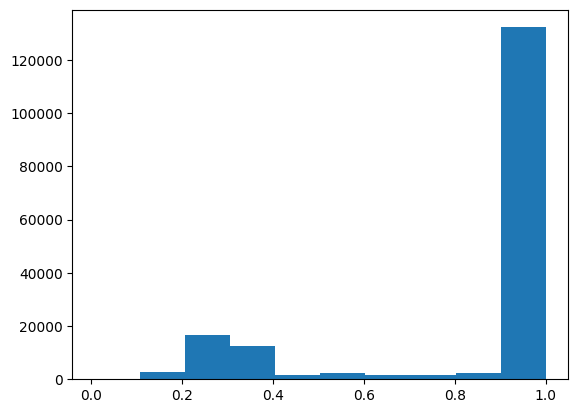

In [356]:
plt.hist(test_predictions['prediction'])
plt.show()

In [357]:
report = classification_report(test_predictions['target'], test_predictions['final_prediction'], output_dict=True)
cl = pd.DataFrame(report).transpose()
cl

,precision,recall,f1-score,support
0,0.415224,0.251264,0.313076,68235.000000
1,0.613625,0.770661,0.683236,105285.000000
accuracy,0.566413,0.566413,0.566413,0.566413
macro avg,0.514424,0.510962,0.498156,173520.000000
weighted avg,0.535606,0.566413,0.537674,173520.000000


In [358]:
cl.iloc[:3,].to_csv('cl.csv')

In [359]:
cm = confusion_matrix(test_predictions['target'], test_predictions['final_prediction'])
cm

array([[17145, 51090],
       [24146, 81139]])